#Visual Translation with Context using LLMs
This is a POC to test whether passing an LLM context about the context of text provided for translation improves the quality of the translation.

Take the following example where google translate struggles with the menu items on this vietnamese menu board.

![img](./example.png)



In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install transformers pytesseract sentencepiece accelerate easyocr

In [22]:
import torch
from transformers import pipeline
import cv2
import pytesseract
from matplotlib import pyplot as plt

# Classification Stage

This assigns a generic label from the iamgenet 1000 classifier which will be used later in creating a prompt to pass to the language model. 

In [14]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image

def classify(input, model="default"):
  """
  Method to classify input image
  """
  if model == "default":
    # Default transformers classifier. Assigns labels from imagenet 1000.
    classifier = pipeline(task="image-classification", device="cpu")
    return classifier(input)[0]
  else:
    raise NotImplementedError(f"Model {model} not implemented.")


image = Image.open("./test_img.jpg")
classify(image)


No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.9984662532806396, 'label': 'menu'}

# OCR

Module to capture text from image

## Bbox locating

In [30]:
import easyocr

def get_bboxes(image, model='easyocr', conf_thresh=0.5, language='en'):
  """
  Get bounding boxes containing text where the model exceeds a
  provided confidence thresold.
  """

  if model == 'easyocr':
    reader = easyocr.Reader([language]) #TODO: does this have its own thresh?
    result = reader.readtext(image) #TODO: does this always produce rectangular boxes?

    sorted_result = sorted(result, key=lambda x: x[2]) #FIXME: sorted right?

    return [x for x in sorted_result if x[2] > conf_thresh]
  else:
    raise NotImplementedError(f"Model {model} is not implemented.")

image = Image.open("./test_img.jpg")
print("\n")
print(get_bboxes(image, language='vi')[0])




([[1278, 1983], [1386, 1983], [1386, 2038], [1278, 2038]], '30K', 0.5058012845190533)




([[1278, 1983], [1386, 1983], [1386, 2038], [1278, 2038]], '30K', 0.5058012845190533)
([[2886, 1031], [3422, 1031], [3422, 1128], [2886, 1128]], 'Thit Nưóna BBQ', 0.5248717809154846)
([[1151, 459], [1725, 459], [1725, 561], [1151, 561]], 'Bánh mì Thit Nưóng', 0.5276787286649851)


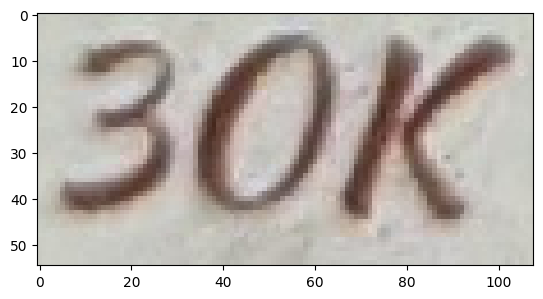

In [38]:
# Get text from cropped bounding boxes

def get_text(image, model='easyocr', conf_thresh=0.5, language='en'):

  if model =='easyocr':
    reader = easyocr.Reader([language])
    result = reader.readtext(image)    
      
    sorted_result = sorted(result, key=lambda x: x[2])
    return [x[:2] for x in sorted_result if x[2] > conf_thresh]

image = Image.open("./test_img.jpg")
result = get_bboxes(image, language='vi')[:3] # get first three boxes



for line in result:
  print(line)
  boxes, text, confidence = line
  ltrb = [x for box in boxes[::2] for x in box]

  # run get_text
#plt.imshow(image.crop(ltrb))
  


In [ ]:
# describe image with image captioning
captioner = pipeline(task="image-to-text", device="cpu")
captioner("./test_img.jpg")

No model was supplied, defaulted to ydshieh/vit-gpt2-coco-en and revision 65636df (https://huggingface.co/ydshieh/vit-gpt2-coco-en).
Using a pipeline without specifying a model name and revision in production is not recommended.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/eoconnell/anaconda3/envs/jupy/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/eoconnell/anaconda3/envs/jupy/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to co

[{'generated_text': 'a sign that says "donuts for sale" '}]

# Query model

Testing some models that we can query with context and succesfully translate a sentence from vietnamese to english. 

[model](https://huggingface.co/bigscience/bloomz-560m?text=Translate+to+English+from+Vietnamese%3A+B%C3%A1nh+m%C3%AC+thit+N%C6%B0%C3%B3ng.)


## Bloomz

Phrase "Translate to English from Vietnamese: Bánh mì thit Nưóng."

Expected output "Hot bread"

Output: "thit Nưóng" - Fail 


Phrase: "Translate to English from French: Je t'aime."

Output: "Je t'aime"


Phrase: "Translate to English: Je t'aime."

Output: "I love you."


Phrase: "Translate from French to English: Je t'aime."

Output: "I love you."

Phrase: "Translate from Vietnamese to English: Je t'aime."

Output: "I love you."

Phrase: "Translate from Vietnamese to English: Bánh mì thit Nưóng."

Output: "</s>"

Phrase: "Translate to English: Bánh mì thit Nưóng."

Output: "</s>"

Phrase: "Translate to English: Bánh mì thit Nuóng."

Output: "</s>"

Phrase: "Translate from Vietnamese to English this text taken from a menu in vietnam: Bánh mì thit Nuóng."

Output: "this text taken from a menu in vietnam: Bánh mì thit Nuóng."

In [ ]:
# pip install -q transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = "bigscience/bloomz-7b1"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint, torch_dtype="auto", device_map="auto")



In [ ]:
for line in result:
  box, text, score = line

  query = f"Translate this Vietnamese text taken from a menu to English. Text: {text}. Translation:"

  inputs = tokenizer.encode(query, return_tensors="pt").to("cuda")
  outputs = model.generate(inputs, max_new_tokens=50)
  print(tokenizer.decode(outputs[0]))

Translate this Vietnamese text taken from a menu to English. Text: NGON. Translation: It's good.</s>
Translate this Vietnamese text taken from a menu to English. Text: NGON. Translation: It's good.</s>
Translate this Vietnamese text taken from a menu to English. Text: Bánh mì Thit Nưóng. Translation: Bánh mì Thit Nưóng.</s>
Translate this Vietnamese text taken from a menu to English. Text: Bánh mì Thit Nưóng. Translation: Bánh mì Thit Nưóng.</s>
Translate this Vietnamese text taken from a menu to English. Text: Bánh mì Gà. Translation: Bánh mì gà.</s>
Translate this Vietnamese text taken from a menu to English. Text: Huóng. Translation: Hello.</s>
Translate this Vietnamese text taken from a menu to English. Text: 2(. Translation: 2) from the menu.</s>
Translate this Vietnamese text taken from a menu to English. Text: Bánh mì Cà #ưóng. Translation: Bánh mì thịt nướng.</s>
Translate this Vietnamese text taken from a menu to English. Text: 2OK. Translation: 2 OK.</s>
Translate this Vietna

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("allenai/tk-instruct-small-def-pos")

model = AutoModelForSeq2SeqLM.from_pretrained("allenai/tk-instruct-large-def-pos")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda:0"

tokenizer = AutoTokenizer.from_pretrained("allenai/mtk-instruct-3b-def-pos")
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/mtk-instruct-3b-def-pos").to(device)

input_ids = tokenizer.encode(
        "Definition: Translate from Vietnamese to English. Now complete the following example - Input: Bánh mì Thit Nưóng. Output:", 
        return_tensors="pt").to(device)
output = model.generate(input_ids, max_length=10)
output = tokenizer.decode(output[0], skip_special_tokens=True)   # model should output 'Indian Rupee'
print(output)

#input_ids = tokenizer.encode(
#        "Definition: negate the following sentence. Input: John went to school. Output:", 
#        return_tensors="pt")
#output = model.generate(input_ids, max_length=10)
#output = tokenizer.decode(output[0], skip_special_tokens=True)   # model should output 'John did not go to shool.'

#print(output)

Bánh mì Thit Nưóng


In [ ]:
input_ids = tokenizer.encode(
    "Definition: A text is given in Vietnamese. Translate it from the Vietnamese language to the English language. The translation must not omit or add information to the original sentence. Input: Bánh mì Thit Nưóng. Output:", 
        return_tensors="pt").to(device)
output = model.generate(input_ids, max_length=50)
output = tokenizer.decode(output[0], skip_special_tokens=True)   # model should output 'Indian Rupee'
print(output)

Bánh mì Thit Nưóng


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# read gps data from image
from PIL import Image
from PIL.ExifTags import TAGS

def get_exif(filename):

    image = Image.open(filename)
    image.verify()
    return image._getexif()

def get_lat_lon(image_path):
    exif = get_exif(image_path)
    exif_data = {}
    if exif:

        for (tag, value) in exif.items():
            if tag in TAGS:
                exif_data[TAGS[tag]] = value

    # retrieve latitude and longitude from exif data
    lat = exif_data['GPSInfo'][2]
    lon = exif_data['GPSInfo'][4]

    # convert to degrees
    lat = lat[0] + lat[1]/60 + lat[2]/3600
    lon = lon[0] + lon[1]/60 + lon[2]/3600
    return lat, lon

lat, lon = get_lat_lon("./test_img.jpg")
print(float(lat), float(lon))



16.049333333333333 108.24576388888889


: 

: 